# Determining Elastic Modulus using MD Analysis

## Importing Libraries

In [1]:
#importing required libraries
from classes.constantsmd import *
from classes.gridmd import *
from classes.functionsmd import *
from numpy import sin, cos, deg2rad, matrix, size, invert, multiply, array, sqrt, ones, empty, sum, average, abs, log, mean
from matplotlib.pyplot import plot, scatter, loglog
import datetime

#import matplotlib.pyplot as plt
#from sympy import init_printing
#from mpl_toolkits.mplot3d import Axes3D
#import csv
#import pandas as pd
print("-----------start-----------")

called constantmd
called gridmd
called functionsmd
-----------start-----------


## Writing Initial Data Log

In [2]:
now = datetime.datetime.now()
file = open("dump/inputdata_"+str(now.strftime("%d-%m-%Y %H:%M"))+".txt", "w")
file.write("datetime : "+str(now.strftime("%d-%m-%Y %H:%M"))+"\n")
file.write("avagadro : "+str(avagadro)+"\n")
file.write("ial : "+str(ial)+"\n")
file.write("epsilon : "+str(epsilon)+"\n")
file.write("sigma : "+str(sigma)+"\n")
file.write("timestep : "+str(ts)+"\n")
file.write("N_steps : "+str(N_steps)+"\n")
file.write("N : "+str(N)+"\n")
file.write("Fa : "+str(Fa)+"\n")
file.write("mass : "+str(mass)+"\n")
file.write("FaByMass : "+str(FaByMass)+"\n")
file.close()

## Initial Assignment

In [3]:
#N = N_xyz(10,6,6)
coor_0 = initialPosSC(N,ial)

xyz_grid = xyzGrid(coor_0[0], coor_0[1], coor_0[2])

In [4]:
time_grid = np.zeros([N_steps,N[0],N[1],N[2],3])
time_grid[0] = np.array([xyz_grid])

force_grid = np.zeros([N_steps, N[0], N[1], N[2],3])

## Assigning Force Along X-Axis

In [5]:
#%%timeit
for t in range(N_steps):
    for j in array(range(N[1])):
        for k in array(range(N[2])):
            force_grid[t, 0, j, k, 0] = -Fa / (N[1] * N[2])
            force_grid[t, N[0]-1, j, k, 0] = Fa / (N[1] * N[2])

## Determining Position and Force for each timestep

In [6]:
for t in range(N_steps):
    file = open("dump/pos/timestep_"+str(t+1)+".xyz", "w")
    file.write(str(N[0]*N[1]*N[2])+'\n')
    file.write('\n')
    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                fx=0; fy=0; fz=0;acc=0
                fx = forceXLJ3(i, j, k, xyz_grid)
                fy = forceYLJ3(i, j, k, xyz_grid)
                fz = forceZLJ3(i, j, k, xyz_grid)
                #fx, fy, fz += forceLJ3(i, j, k, xyz_grid)
                force_grid[t][i][j][k][0] += fx;force_grid[t][i][j][k][1] += fy;force_grid[t][i][j][k][2] += fz
                if (t!=N_steps-1):
                    acc = (fx/mass) + (force_grid[t, i, j, k , 0]/mass)
                    if (t-1==-1):
                        xj=verlet_posd(time_grid[t][i][j][k][0],t,ts,acc)
                        yj=verlet_posd(time_grid[t][i][j][k][1], t, ts, fy/mass)
                        zj=verlet_posd(time_grid[t][i][j][k][2], t, ts, fz/mass)
                    else:
                        xj=verlet_posd(time_grid[t][i][j][k][0],t,ts,acc)
                        yj=verlet_posd(time_grid[t][i][j][k][1], t, ts, fy/mass)
                        zj=verlet_posd(time_grid[t][i][j][k][2], t, ts, fz/mass)
                    time_grid[t+1][i][j][k][0] = xj
                    time_grid[t+1][i][j][k][1] = yj
                    time_grid[t+1][i][j][k][2] = zj
                    file.write('X '+str(xj)+' '+str(yj)+' '+str(zj)+'\n')
                
    file.close()

## Ploting the positions along various timesteps

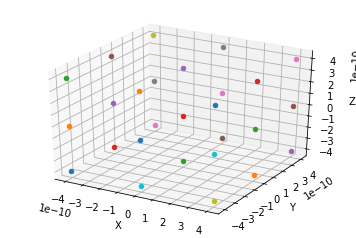

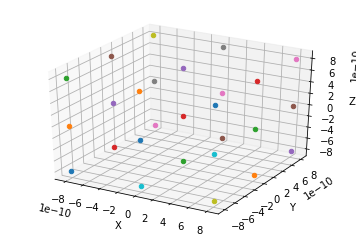

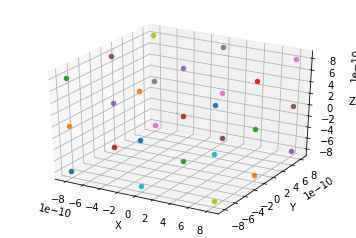

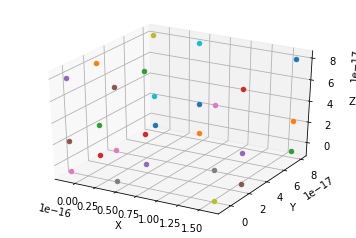

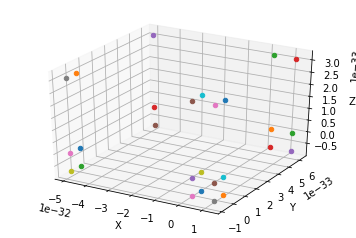

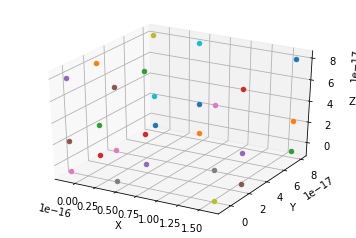

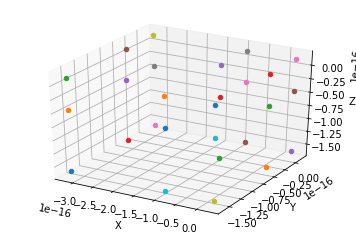

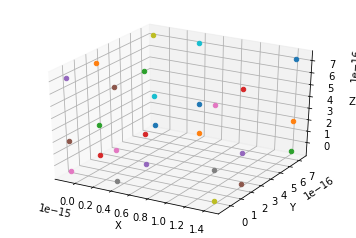

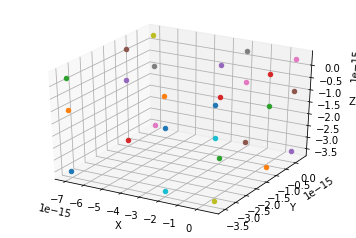

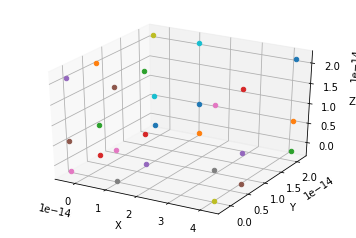

In [7]:
for time in range(N_steps):
    fig0 = plt.figure()
    ax = fig0.add_subplot(111, projection='3d')
    for i in time_grid[time,:,0,0,0]:
        for j in time_grid[time,0,:,0,1]:
            for k in time_grid[time,0,0,:,2]:
                ax.scatter(i,j,k)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

## Calculating the Mean Force and Stress

In [8]:
time_forceMean, time_stress, time_stress_applied = timeForceMeanAndTimeStress(force_grid, time_grid)

## Determining the Strain

In [9]:
strainXYZ = np.zeros([N[0], N[1], N[2], 3])
time_strainXYZ = np.zeros([N_steps, N[0], N[1], N[2], 3])
time_strainXYZ[0] = strainXYZ
for t in range(N_steps):
    if t==0:
        pass #strainX[t] = 0
    else:
        strainXYZ = abs(time_grid[t]-time_grid[0])/ial
        time_strainXYZ[t] = strainXYZ

In [10]:
def timeStrainMean():
    time_strainMean = np.zeros([N_steps, 3])
    StrainXMean = 0;StrainYMean = 0;StrainZMean = 0;
    for t in range(N_steps):
        for i in range(N[0]):
            for j in range(N[1]):
                for k in range(N[2]):
                    StrainXMean+=time_strainXYZ[t][i][j][k][0]
                    StrainYMean+=time_strainXYZ[t][i][j][k][1]
                    StrainZMean+=time_strainXYZ[t][i][j][k][2]
        StrainXMean = StrainXMean/N[0];StrainYMean = StrainYMean/N[1];StrainZMean = StrainZMean/N[2];
        time_strainMean[t] = np.array([StrainXMean, StrainYMean, StrainZMean])
    return time_strainMean

## Strain-Time Diagram

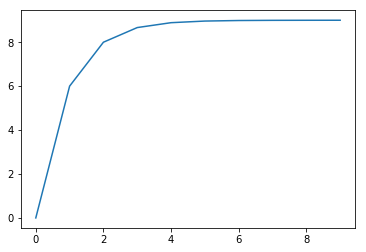

In [11]:
time_strainMean = timeStrainMean()
plot(range(N_steps) ,time_strainMean[:,0])

## Stress-Time Diagram

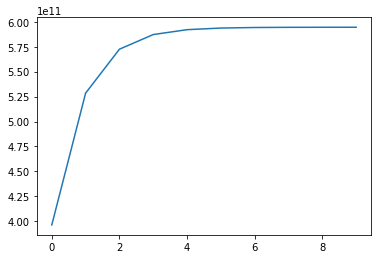

In [12]:
plot(range(N_steps) ,time_stress[:,0])

## Stress-Strain Diagram

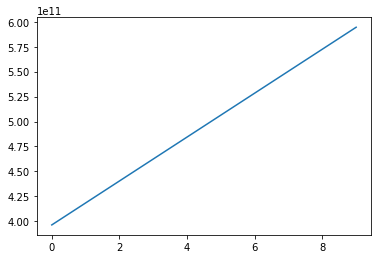

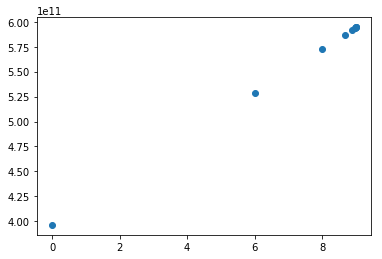

In [13]:
n=N_steps
#fig, axs = plt.subplot(1,2)

plot(time_strainMean[:n,0], time_stress[:n,0])
plt.show()
scatter(time_strainMean[:n,0], time_stress[:n,0])
plt.show()

## Computed Young's Modulus

In [14]:
for i in range(N_steps):
    print( (time_stress[i][0]/time_strainMean[i][0])/1e9,"GPa")

inf GPa
88.07936153359604 GPa
71.56448820402332 GPa
67.75333593291731 GPa
66.61000523065138 GPa
66.24147941446934 GPa
66.1200130132538 GPa
66.07953376601473 GPa
66.06643555194391 GPa
66.05807807227598 GPa


/home/krish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [15]:
import platform
platform.system()
if(platform.system()=='Windows'):
    import winsound
    duration = 1000  # millisecond
    freq = 440  # Hz
    winsound.Beep(freq, duration)
if(platform.system()=='Linux'):
    import os
    os.system('spd-say "your program is finished"')


In [16]:
print("------------end------------")

------------end------------
